## Import Libraries

In [447]:
from tensorflow import keras
from tensorflow.keras import backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [448]:
pd.set_option('display.max_rows', 50)

## Import Datasets

In [449]:
train_data = pd.read_csv("Kaggle_Dataset/PM_train.txt", sep=" ", header=None)
test_data = pd.read_csv("Kaggle_Dataset/PM_test.txt", sep=" ", header=None)
ground_truth = pd.read_csv("Kaggle_Dataset/PM_truth.txt", sep=" ", header=None)

### Drop Empty Columns

In [450]:
train_data.dropna(axis=1, inplace=True)
test_data.dropna(axis=1, inplace=True)
ground_truth.dropna(axis=1, inplace=True)

### Label Columns

In [451]:
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_data.columns = cols_names
test_data.columns = cols_names

### Sort columns by the attributes 'id' and 'cycle'

In [452]:
train_data = train_data.sort_values(['id', 'cycle'])
test_data = test_data.sort_values(['id', 'cycle'])

### Normalize training data in all columns that are different to 'id' and 'cycle'

In [453]:
norm_cols = train_data.columns.difference(['id', 'cycle'])

min_max_scaler = preprocessing.MinMaxScaler()

norm_train_data = pd.DataFrame(min_max_scaler.fit_transform(train_data[norm_cols]), 
                               columns=norm_cols, index=train_data.index)

join_train_data = train_data[["id", "cycle"]].join(norm_train_data)

train_data = join_train_data.reindex(columns = train_data.columns)


### Normalize test data in all columns that are different to 'id' and 'cycle'

In [454]:
norm_cols = test_data.columns.difference(['id', 'cycle'])

min_max_scaler = preprocessing.MinMaxScaler()

norm_test_data = pd.DataFrame(min_max_scaler.fit_transform(test_data[norm_cols]), 
                               columns=norm_cols, index=test_data.index)

join_test_data = test_data[["id", "cycle"]].join(norm_test_data)

test_data = join_test_data.reindex(columns = test_data.columns)

In [455]:
def create_rul_column(data):
    rul = pd.DataFrame(data.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    data = data.merge(rul, on=['id'], how='left')
    data['RUL'] = data['max'] - data['cycle']
    data.drop('max', axis=1, inplace=True)
    return data

train_data = create_rul_column(train_data)
test_data = create_rul_column(test_data)

In [456]:
# Remove columns with only one unique value
train_data = train_data.loc[:, train_data.apply(pd.Series.nunique) != 1]
test_data = test_data.loc[:, test_data.apply(pd.Series.nunique) != 1]

# Fill missing values with the mean
train_data = train_data.fillna(train_data.mean())

In [457]:
# smooth the data using rolling average on sensors
omit_cols = ['id', 'cycle', 'RUL']
sensor_cols = train_data.columns.difference(omit_cols)

train_data_smooth = train_data.copy()
train_data_smooth.loc[:, sensor_cols] = train_data_smooth.loc[:, sensor_cols].rolling(window=5).median()
train_data_smooth = train_data_smooth.fillna(train_data)
#train_data = train_data_smooth

test_data_smooth = test_data.copy()
test_data_smooth.loc[:, sensor_cols] = test_data_smooth.loc[:, sensor_cols].rolling(window=5).median()
test_data_smooth = test_data_smooth.fillna(test_data)
#test_data = test_data_smooth

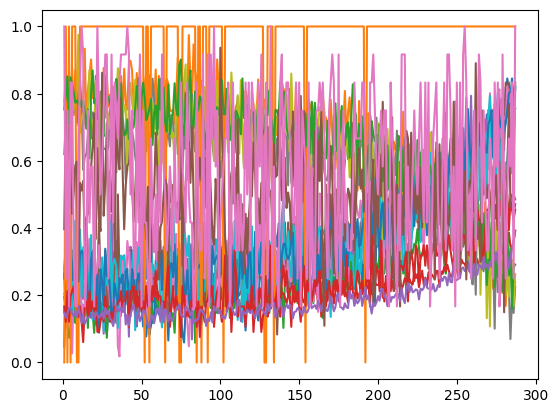

In [458]:
# EDA
# Plot Sensor data in relation to cycles

# Plot dynamic sensor data
for i in train_data.columns.difference(['id', 'cycle', 'RUL']):
    plt.plot(train_data[train_data["id"] == 2]["cycle"], train_data[i][train_data["id"] == 2], label=i)
    #plt.show()
    #print(i)


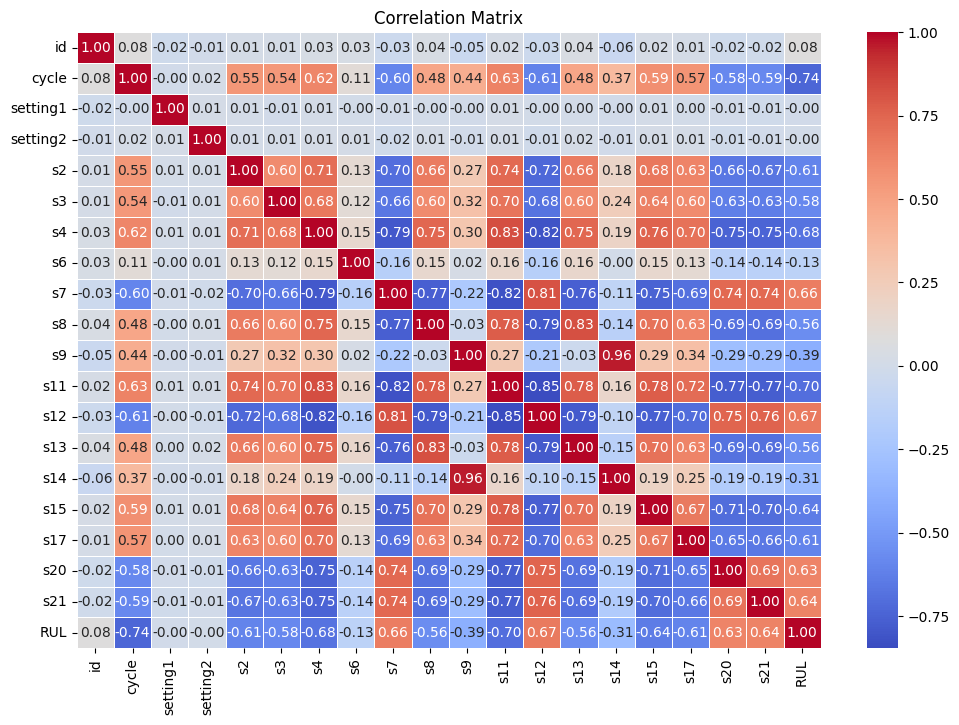

In [459]:
# Compute the correlation matrix
corr = train_data.corr()

# Generate a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [460]:
# Set up the data for the model
X_train = train_data.drop(['RUL'], axis=1)
X_test = test_data.drop(['RUL'], axis=1)

y_train = train_data['RUL']
y_test = test_data['RUL']

In [461]:
# Training the model	
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, max_features=2, n_jobs=-1, verbose=1)
history = model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.0s finished


Root Mean Squared Error:  52.65985929950141
Mean Squared Error:  2773.060781443285
Mean Absolute Error:  41.65158916196987
R2 Score:  0.014866919160497316


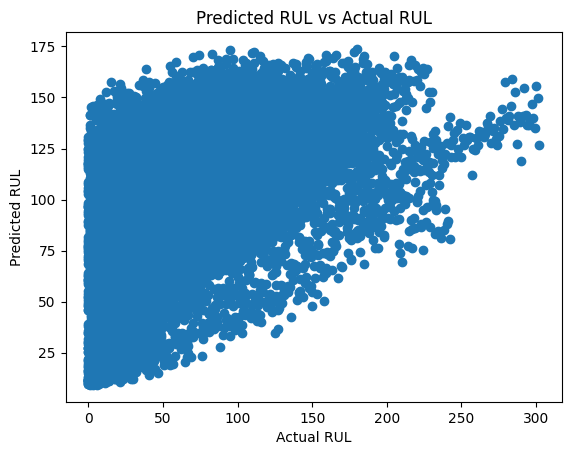

In [462]:
# Evaluate the model
y_pred = model.predict(X_test)

print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("R2 Score: ", r2_score(y_test, y_pred))

# Plot the predicted RUL vs the actual RUL
plt.plot(y_test, y_pred, 'o')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Predicted RUL vs Actual RUL')
plt.show()
